We're going to investigate the RHL's reinterpretation of the ZOGY (2016) algorithm which is described in RHL's slides as a post-convolution (in Fourier space) of the diffim:

$$
D(k) = [I_1(k) - \kappa(k) I_2(k)] \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}},
$$

where $I_1$ and $I_2$ are the two images, $\sigma_1$ and $\sigma_2$ are their respective variances, and $\kappa$ is the PSF-matching kernel. Note that this is for the case of "preconvolution" of $I_1$ with its own PSF, so that if $I_1$ and $I_2$ have the same seeing, then $\kappa$ = $\phi_1$ (where $\phi_1$ is the PSF of $I_1$). The resulting PSF of the diffim $D$ is:

$$
\phi_D(k) = \phi_1(k) \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

Thus, we may interpret the image difference as being **post-convolved** with a kernel of the form

$$
\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

If we wish to incorporate this post-convolution into our current framework which works in real-space, it is "simply" a matter of inverse Fourier-transforming the kernel into real-space, and then convolving it with the diffim.

But what does this post-convolution kernel (and the PSF of the image difference) actually look like?

In [1]:
import sympy as sym
import sympy.stats as symstat
from sympy.interactive import printing
sym.init_printing()

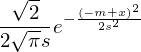

In [2]:
x,F,m,s,k,n = sym.symbols("x F m s k n")
G = 1/(s*sym.sqrt(2*sym.pi)) * sym.exp(-(x-m)**2/(2*s**2))
G

In [3]:
G.evalf(subs={x: 0, m: 0, s: 1})

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

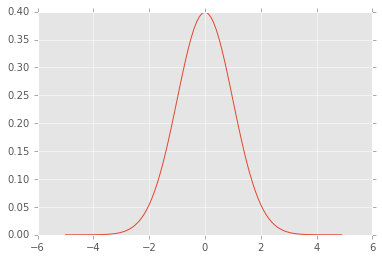

In [5]:
qq = [G.evalf(subs={x: xx, m: 0, s: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)

In [6]:
H = sym.fourier_transform(G, x, k)
H

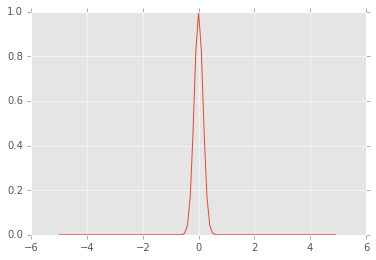

In [7]:
qq = [H.evalf(subs={k: xx, m: 0, s: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)

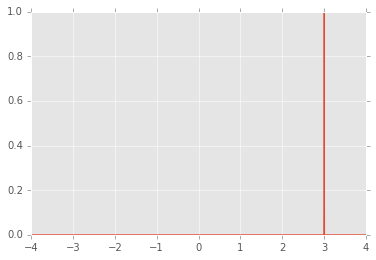

In [8]:
D = sym.KroneckerDelta(x, 3.0)
xrange = np.arange(-4,4,0.01)
xrange[np.abs(xrange-3.0) <= 1e-5] = 3.0
qq = [D.evalf(subs={x: xx}) for xx in xrange]
plt.plot(xrange, qq)

Looks like sympy doesn't handle Fourier transforms of Delta functions correctly. See:
http://stackoverflow.com/questions/33208737/continuous-fourier-transform-with-python-sympy-analytical-solution

Numerical try, see:

http://www.leadnovo.com/4444999026.htm

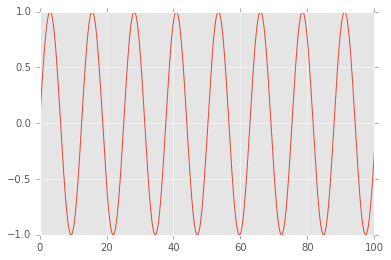

In [9]:
from scipy.fftpack import fft, fftfreq
t = np.linspace(0., 100., 2000)
signal = np.sin(t / 2.)
plt.plot(t, signal)

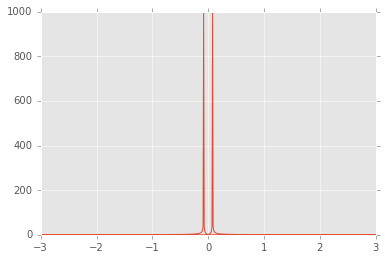

In [10]:
npts = len(t)
FFT = fft(signal)
freqs = fftfreq(npts, t[1]-t[0])
plt.plot(freqs, np.abs(FFT))
plt.xlim(-3, 3)

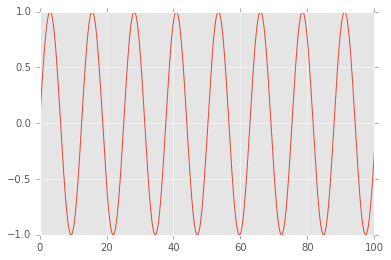

In [11]:
from scipy.fftpack import ifft
signal2 = ifft(FFT)
plt.plot(t, signal2.real)

### Let's take a look at the Lupton(ZOGY) "post-convolution" kernel...

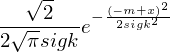

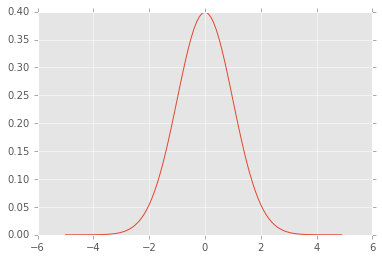

In [12]:
# Define kappa(x) (the spatial matching kernel) as a simple narrow Gaussian:
sigk = sym.symbols("sigk")

kappa = 1/(sigk*sym.sqrt(2*sym.pi))*sym.exp(-(x-m)**2/(2*sigk**2))
qq = [kappa.evalf(subs={x: xx, m: 0, sigk: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
kappa

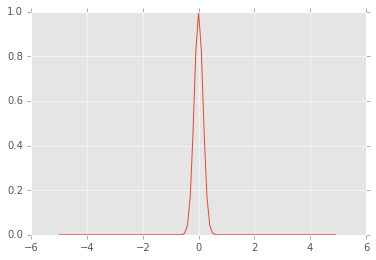

In [13]:
# Now define kappa_ft(k) (the FT of the matching kernel kappa):
kappa_ft = sym.fourier_transform(kappa, x, k)
qq = [kappa_ft.evalf(subs={k: xx, m: 0, sigk: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
kappa_ft

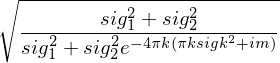

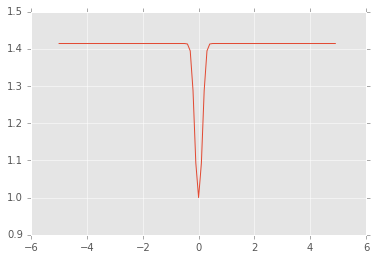

In [14]:
sig1, sig2 = sym.symbols("sig1 sig2")
# post_conv_kernel = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
post_conv_kernel_ft = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft**2))
qq = [post_conv_kernel_ft.evalf(subs={k:xx, m:0, sigk:1, sig1:1, sig2:1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
post_conv_kernel_ft

In [15]:
# This takes a long time so let's look at it numerically instead...
if False:
    post_conv_kernel = sym.inverse_fourier_transform(post_conv_kernel_ft, k, x, noconds=False)
    post_conv_kernel

## Let's do the calculations (FFTs and iFFTs) numerically instead...

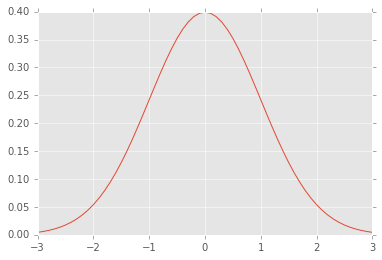

In [16]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

x = np.arange(-5,5,0.1)
plt.plot(x, gaussian(x))
plt.xlim(-3, 3)

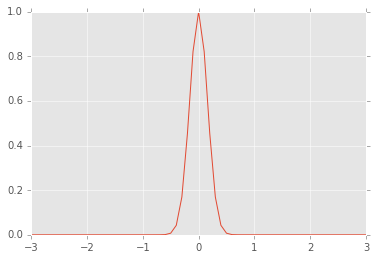

In [17]:
def gaussian_ft(x, m=0., s=1.0):
    kp = gaussian(x, m, s)
    npts = len(x)
    FFT = fft(kp)
    FFT *= (x[1]-x[0])
    freqs = fftfreq(npts, x[1]-x[0])  # assumes uniformly sampled x!
    return FFT, freqs

FFT, freqs = gaussian_ft(x, s=1.)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(abs(FFT)))
plt.xlim(-3, 3)

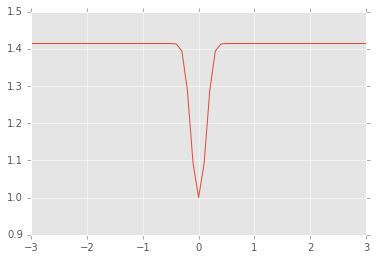

In [18]:
# post_conv_kernel = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
def post_conv_kernel_ft(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft, freqs = gaussian_ft(x, m, sigk)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2)), freqs

kft, freqs = post_conv_kernel_ft(x, sigk=1.)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(kft.real))
plt.xlim(-3, 3)

-0.0135174826775
-0.0134769965608
1.0


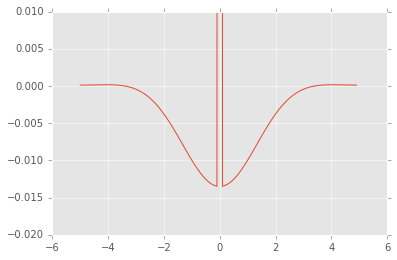

In [19]:
def post_conv_kernel(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft, freqs = post_conv_kernel_ft(x, sig1, sig2, m, sigk)
    out = ifft(kft)
    return out

pck = post_conv_kernel(x, sigk=1.)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.02, 0.01)

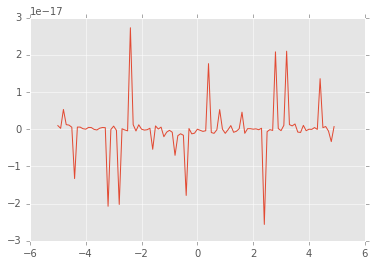

In [20]:
# Ensure there is no trend in the imag. component:
plt.plot(x, np.fft.ifftshift(pck.imag))

Do it with the "pre-filtering" option turned on (a kernel with width `sigM`)

1.0


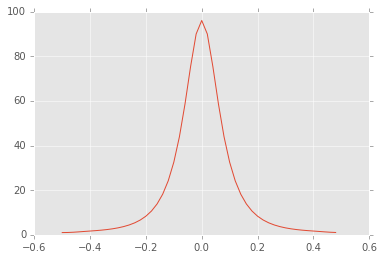

In [55]:
def post_conv_kernel_ft2(x, sig1=1., sig2=1., m=0., sigk=1., sigM=2., delta=1e-5):
    kft, freqs = gaussian_ft(x, m, sigk)
    mft, freqs = gaussian_ft(x, m, sigM)
    return np.sqrt((sig1**2 + sig2**2 + delta) / (sig1**2 * mft**2 + sig2**2 * kft**2 + delta)), freqs

x = np.arange(-25,25,1)
kft, freqs = post_conv_kernel_ft2(x, sigk=1., sigM=3., delta=1e-5)
print kft.real.min()
plt.plot(np.fft.fftshift(freqs), kft.real)
#plt.xlim(-3, 3)#; plt.ylim(-0.05, 0.05)

1.0


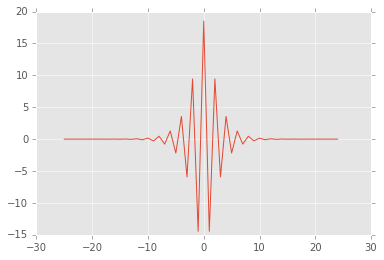

In [56]:
pck = ifft(kft)
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
#plt.ylim(-0.02, 0.01)

Look at the two "kernels" computed as part of real ZOGY, where here the 2 kernels are actually the two images' PSFs.

Given eq. 13 in the ZOGY paper, we'll set sigR to sigma of P_r and sigN to sigma of P_n.

Then sig1 is noise of N and sig2 is noise of R.

-1.0


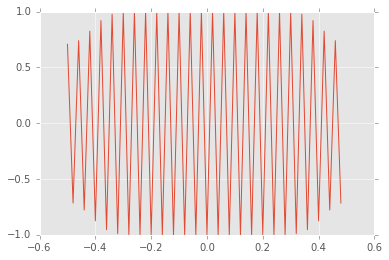

In [57]:
def post_conv_kernel_ft3(x, sig_r=1., sig_n=1., m=0., sigR=1., sigN=2.):
    P_r, freqs = gaussian_ft(x, m, sigR)
    P_n, freqs = gaussian_ft(x, m, sigN)
    return P_r / np.sqrt(sig_n**2 * np.abs(P_r)**2 + sig_r**2 * np.abs(P_n)**2), freqs

x = np.arange(-25,25,1)
kft, freqs = post_conv_kernel_ft3(x, sig_r=1., sig_n=1., sigR=1., sigN=2.)
print kft.real.min()
plt.plot(np.fft.fftshift(freqs), kft.real)
#plt.xlim(-3, 3)#; plt.ylim(-0.05, 0.05)

0.707106781187 0.94481446857


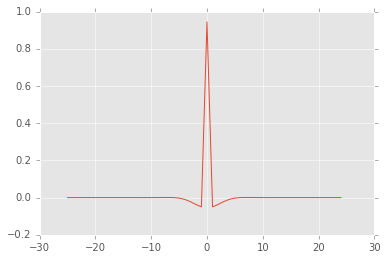

In [59]:
pck = ifft(kft)
print pck.real.sum(), pck.real.max()
#plt.plot(x, np.fft.ifftshift(pck.real))
plt.plot(x, pck.real)
#plt.ylim(-0.02, 0.01)